In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import json
import folium
from pysal.esda.mapclassify import Natural_Breaks as nb

# data paths
TASK_1_DATA_PATH = './data/lfsa_urgan_1_Data.csv'
AMSTAT_UNEMPLOYED_PATH = './data/Arbeitslosenquoten_task_2_1.csv'
AMSTAT_JOBSEEKING_PATH = './data/TASK_2_demandeurs_emploi.csv'
PATH_TASK_3_1 = './data/amstat_3ch.csv'
PATH_TASK_3_2 = './data/task_3_2.csv'

# Task 1: European unemployment rate (Eurostat)

### Getting the data from [Eurostat](http://ec.europa.eu/eurostat/data/database)

Database by themes/Population and social conditions/Labour market (Labour)/Employment and Unemployment(Labour Force survey)(employ)/LFS series - detailed annual survey results (LFSA)/ Total unemployment - LFS series(lfsa_unemp)/  Unemployment rates by sex, age and nationality (%) (lfsa_urgan)



Age from 15 to 74

How we got the data:
- we used the data explorer, then 'Download' button, 'Change Selection' to keep only what we're interested in, then download data in CSV format

### Data importing and cleaning
First, we import the unemployement rates from the Eurostat website in a dataframe. Since we are looking for recent statistics, we only keep the data from last year (2016). We also discard all columns except the ones we need (Country and unemployment rate). A few countries also need to be renamed, so that the countries' names are consistent between the eurostat DataFrame and the topojson file. We also drop some unwanted rows, such as the average rate for countries from the European Union.

In [2]:
df = pd.read_csv(TASK_1_DATA_PATH)
df = df[df['TIME']==2016] # only keep data from last year
df = df[['GEO', 'Value']] # The only information we need is the country and the unemployment rate
df.rename(columns={'GEO': 'Country', 'Value' : 'Unemployment rate' }, inplace=True)
df.index = (range(len(df))) # re-index the dataframe

# drop unwanted rows, rename some countries to match with the topojson data
df = df.replace(to_replace='Former Yugoslav Republic of Macedonia, the', value='The former Yugoslav Republic of Macedonia')
df = df.replace(to_replace='Germany (until 1990 former territory of the FRG)', value='Germany')
df = df.drop(index=[0,1, 2, 3, 4, 5])

df.index = (range(len(df))) # re-index the dataframe
df.head()

,Country,Unemployment rate
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany,4.1


Then, we import the topojson data:

In [3]:
state_geo_path = r'topojson/europe.topojson.json'
geo_json_data = json.load(open(state_geo_path))

Now, let's see if we are missing some data. To do this, we extract the list of countries from the topojson file and check if some of these countries are not in our DataFrame:

In [4]:
# First, extract the list of countries from the topojson
countries = [country['properties']['NAME'] for country in geo_json_data['objects']['europe']['geometries']]
# From this list, print each country that does not appear in the DataFrame
missing_countries = set(countries).difference(set(df.Country.values))
print("The data is missing for %d out of %d countries:\n" %(len((missing_countries)), len(countries)))
print('\n'.join(missing_countries))

The data is missing for 18 out of 51 countries:

San Marino
Andorra
Bosnia and Herzegovina
Montenegro
Ukraine
Serbia
Faroe Islands
Georgia
Russia
Holy See (Vatican City)
Republic of Moldova
Azerbaijan
Israel
Monaco
Armenia
Liechtenstein
Albania
Belarus


Let's ensure that each countries from the DataFrame has been matched to a country in the topojson:

In [5]:
assert(not set(df.Country.values).difference(set(countries)))

Because we don't have the unemployment rate of some countries in topojson file, we need to delete them such that our choropleth plot does not get spoiled.

In [6]:
index_to_keep = [country['properties']['NAME'] in df.Country.values 
                for country in geo_json_data['objects']['europe']['geometries']]
geo_json_data['objects']['europe']['geometries'] = np.array(geo_json_data['objects']['europe']['geometries'])[index_to_keep].tolist()

### Technique to have propoer breaks

In [7]:
def compute_breaks(serie):
    breaks = nb(serie.values, k = 5)
    scales = [min(serie.values)]
    for x in breaks.bins[0:len(breaks.bins)]:
        scales.append(x+0.01)
    return scales

thresh = compute_breaks(df['Unemployment rate'])

In [8]:
thresh

[3.0,
 5.1099999999999994,
 7.0099999999999998,
 8.8100000000000005,
 13.109999999999999,
 23.710000000000001]

### Build the choropleth map

In [9]:
m = folium.Map([53, 15],  tiles='cartodbpositron', zoom_start=4)
#ignore_missing_countries = lambda x: {'fillOpacity':1,'fillColor':'YlOrRd' if x['properties']['NAME'] in df.Country.values else 'black'}
#folium.TopoJson(open(state_geo_path), 'objects.europe', style_function =ignore_missing_countries).add_to(m)
m.choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=df,
    columns=['Country', 'Unemployment rate'],
    key_on='feature.properties.NAME',
    topojson='objects.europe',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Unemployment Rate (%)',
    threshold_scale= thresh
)
m

In [10]:
from IPython.display import IFrame

IFrame('http://localhost:8888/notebooks/ADA_HW/AppliedDataAnalysis/Homeworks/03%20-%20Interactive%20Viz/europe_unemployment_rate.html', width=800, height=600)

# Task 2: Unemployment rate in Switzerland

The goal of task 2 is to compute and plot the unemployment rate for each canton in Switzerland. We got the data from Amstat's website. We will address two definitions of *unemployment rate*:
- The first one is the ratio of **jobseeking** people over the total active population.
- The second one is the ratio of **unemployed** people over the total active population.

Note that we consider the total **active** population, and not the total population, as children and elders should obviously not be taken into account.

We are interested in recent data, but we also want to tackle the seasonality problem (i.e. unemployment may be higher at some periods of the year). Thus, taking the average of all the monthly ratios of 2017 (January-September) seemed to be a good compromise.

## Task 2.1
#### Compute the jobseeking ratio

In this section we compute the unemployment ratio in Switzerland's cantons, including the people that have a job but are looking for a new one. In other words, we are computing the jobseeking ratio.

In [11]:
# import topojson data
topo_ch = r'topojson/ch-cantons.topojson.json'
topo_ch_data = json.load(open(topo_ch))

#### Cleaning the data
First, we clean the data by getting rid of unwanted rows and columns. Read the comments for more information about the process.

In [12]:
df_ch = pd.read_csv(AMSTAT_JOBSEEKING_PATH)

# init new dataframe for jobseekers ratio
jobseekers_ratio_df = pd.DataFrame()

# set cantons as index
df_ch.set_index('Kanton', drop=True, inplace=True)

# drop unwanted columns
cols_to_drop = [i for i in range(len(df_ch.columns)-6, len(df_ch.columns))]
cols_to_drop.append(0)
df_ch.drop(df_ch.columns[cols_to_drop],axis=1, inplace=True)

# cast values to float and drop non-numerical characters
df_ch = df_ch.replace({"'":""}, regex = True)
df_ch.iloc[1:len(df_ch)] = df_ch.iloc[1:len(df_ch)].astype(float)

#for each month, compute the percentage of unemployed people, including those that already have a job but are looking for a new one
for i in range(0, len(df_ch.columns), 3):  
    unemployed_ratio = df_ch.iloc[1:len(df_ch)-1,i]
    unemployed = df_ch.iloc[1:len(df_ch)-1,i+1]
    jobseekers = df_ch.iloc[1:len(df_ch)-1,i+2]
    jobseekers_ratio = (jobseekers*unemployed_ratio)/unemployed
    jobseekers_ratio_df[list(df_ch.columns.values)[i]] = jobseekers_ratio

    
# Now let's aggregate this dataframe to compute, for each canton, the average jobseeking rate from january to september 2017
jobseekers_ratio_df['jobseeking rate'] = jobseekers_ratio_df.mean(axis=1)

jobseekers_ratio_df.head()

,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017,jobseeking rate
Kanton,,,,,,,,,,
Zürich,4.73727,4.77932,4.68836,4.46131,4.37549,4.27773,4.26482,4.26847,4.14012,4.443655
Bern,3.81963,3.82967,3.77787,3.50355,3.4347,3.21943,3.24659,3.32508,3.23063,3.487461
Luzern,3.50853,3.59513,3.37147,3.21569,3.12685,3.02621,2.98542,3.09003,2.95629,3.208402
Uri,2.34343,2.31812,2.18867,2.07368,1.83163,1.47925,1.43798,1.30244,1.37679,1.816888
Schwyz,2.87737,2.90827,2.83066,2.72165,2.63023,2.54004,2.62225,2.59754,2.60433,2.703594


Let's then tackle the problem of cantons names: Some names need to be translated so that the names match between the topojson and the data from Amstat:

In [13]:
# First, extract the list of cantons from the topojson
cantons_topo = [canton['properties']['name'] for canton in topo_ch_data['objects']['cantons']['geometries']]
# From this list, print each canton that does not appear in the DataFrame
missing_cantons = set(cantons_topo).difference(set(df_ch.index.values))
print("Some names are not matching %d / %d" %(len(missing_cantons), len(cantons_topo)))
print('\n'.join(missing_cantons))

Some names are not matching 8 / 26
Valais/Wallis
Neuchâtel
Graubünden/Grigioni
Fribourg
Vaud
Ticino
Bern/Berne
Genève


In [14]:
# replace a few names for the cantons whose names are not matching between topojson and dataframe
jobseekers_ratio_df = jobseekers_ratio_df.rename(index={'Genf':'Genève', 'Waadt':'Vaud', 'Neuenburg':'Neuchâtel', 'Graubünden':'Graubünden/Grigioni', 'Tessin':'Ticino', 'Bern':'Bern/Berne', 'Wallis':'Valais/Wallis','Freiburg':'Fribourg'})

# assert that every name is matching
assert(set(cantons_topo) == set(jobseekers_ratio_df.index.values))

# we need a 'cantons' column to bind the data with folium
jobseekers_ratio_df['cantons'] = jobseekers_ratio_df.index

Now let's plot the average jobseeking rate from january to september 2017 for each canton:

In [15]:
map_jobseeking = folium.Map([46.9, 8.2],  tiles='cartodbpositron', zoom_start=8)
map_jobseeking.choropleth(
    geo_data=topo_ch_data,
    name='choropleth',
    data=jobseekers_ratio_df,
    columns=['cantons', 'jobseeking rate'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Jobseeking Rate (%)',
    threshold_scale=compute_breaks(jobseekers_ratio_df['jobseeking rate'])
)
map_jobseeking

## Task 2.2
#### Compute the unemployment ratio

In this section we compute the unemployment ratio in Switzerland's cantons, **excluding the people that have a job but are looking for a new one**. This seems to be a better alternative than what we did in 2.1, since the people looking for a new job are not considered as unemployed anymore. Note that this is how Amstat computes the unemployment rate by default.

In [16]:
df_ch = pd.read_csv(AMSTAT_UNEMPLOYED_PATH)

# drop unwanted columns
cols_to_drop = [i for i in range(1, len(df_ch.columns), 2)]
cols_to_drop.append(20)
cols_to_drop.append(22)
df_ch.drop(df_ch.columns[cols_to_drop],axis=1, inplace=True)

#drop unwanted row
df_ch.drop(index=[0, len(df_ch)-1], axis=0, inplace=True)

# set cantons as index
df_ch.set_index('Kanton', drop=True, inplace=True)

# cast dataframe values as float
df_ch=df_ch.astype(float)

# compute the average unemployment rate for each canton
df_ch['unemployment rate'] = df_ch.mean(axis=1)
df_ch.head()

,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017,unemployment rate
Kanton,,,,,,,,,,
Zürich,3.9,3.9,3.8,3.6,3.5,3.4,3.4,3.4,3.3,3.577778
Bern,3.0,3.0,2.9,2.7,2.6,2.4,2.4,2.5,2.4,2.655556
Luzern,2.2,2.2,2.0,1.9,1.8,1.7,1.7,1.8,1.7,1.888889
Uri,1.5,1.4,1.3,1.2,1.0,0.8,0.7,0.6,0.6,1.011111
Schwyz,2.0,2.0,1.9,1.8,1.7,1.6,1.7,1.7,1.7,1.788889


In [17]:
# replace a few names for the cantons whose names are not matching between topojson and dataframe
df_ch = df_ch.rename(index={'Genf':'Genève', 'Waadt':'Vaud', 'Neuenburg':'Neuchâtel', 'Graubünden':'Graubünden/Grigioni', 'Tessin':'Ticino', 'Bern':'Bern/Berne', 'Wallis':'Valais/Wallis','Freiburg':'Fribourg'})

# assert that every name is matching
assert(set(cantons_topo) == set(df_ch.index.values))

# we need a 'cantons' column to bind the data with folium
df_ch['cantons'] = df_ch.index

In [18]:
map_ch = folium.Map([46.9, 8.2],  tiles='cartodbpositron', zoom_start=8)
map_ch.choropleth(
    geo_data=topo_ch_data,
    name='choropleth',
    data=df_ch,
    columns=['cantons', 'unemployment rate'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Unemployment Rate (%)',
    threshold_scale=compute_breaks(df_ch['unemployment rate'])
)
map_ch

In [19]:
#Here we compute the taux d'evolution
df_ch['diff'] = (jobseekers_ratio_df['jobseeking rate'] - df_ch['unemployment rate'])/df_ch['unemployment rate']
map_ch3 = folium.Map([46.9, 8.2],  tiles='cartodbpositron', zoom_start=8)
map_ch3.choropleth(
    geo_data=topo_ch_data,
    name='choropleth',
    data=df_ch,
    columns=['cantons', 'diff'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='YlGnBu',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Difference between Jobseeking and Unemployment (%)',
    threshold_scale=compute_breaks(df_ch['diff'])
)
map_ch3

## Task 3


In [20]:
df_3 = pd.read_csv(PATH_TASK_3_1)
df_3.drop(index=[0,1,2,3], inplace=True)
df_3.rename(columns={'2 Arbeitslosenquoten': 'canton'}, inplace=True)
df_3.set_index('canton', drop=True, inplace=True)
df_3.drop(df_3.columns[1 -1], axis=1, inplace=True)
df_3.drop(columns='Unnamed: 20', inplace=True)
df_3.drop(columns='Unnamed: 21', inplace=True)
#column_names = df_3.loc[2]
#df_3.columns = column_names

# cast dataframe values as float
df_3=df_3.astype(float)

#df_3.drop(index=[0,1], axis=0, inplace=True)
df_3.head()

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
canton,,,,,,,,,,,,,,,,,,
Zürich,6.6,2.9,6.5,2.8,6.3,2.8,6.0,2.7,5.7,2.6,5.6,2.6,5.5,2.6,5.3,2.6,5.3,2.5
Bern,7.5,2.2,7.4,2.1,7.1,2.1,6.8,2.0,6.2,1.9,5.7,1.8,5.5,1.8,5.5,1.9,5.5,1.8
Luzern,5.4,1.5,5.1,1.5,4.8,1.4,4.6,1.3,4.3,1.3,4.1,1.2,3.9,1.3,3.9,1.3,3.9,1.3
Uri,6.9,0.7,6.4,0.7,5.8,0.6,5.3,0.6,4.1,0.6,3.0,0.5,2.7,0.4,2.2,0.4,2.1,0.4
Schwyz,4.6,1.4,4.5,1.4,4.3,1.3,4.0,1.2,3.6,1.2,3.5,1.1,3.5,1.2,3.5,1.2,3.4,1.2


In [21]:
df_3['januar'] = df_3['Unnamed: 2'].sub(df_3['Unnamed: 3'])


In [22]:
def compute_difference(df_3, nb_months=12):
    tmp = []
    for i in range(1,nb_months):
        colnme = np.str(i)
        tmp.append(df_3.iloc[:, 2*i].sub(df_3.iloc[:, 2*i+1]))

    tmp = np.array(tmp)
    df_3['annual_rate_diff'] = np.mean(tmp, axis=0)
    return df_3

In [23]:
new_df = compute_difference(df_3, nb_months=9)

In [24]:
new_df.head()

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,januar,annual_rate_diff
canton,,,,,,,,,,,,,,,,,,,,
Zürich,6.6,2.9,6.5,2.8,6.3,2.8,6.0,2.7,5.7,2.6,5.6,2.6,5.5,2.6,5.3,2.6,5.3,2.5,3.7,3.1250
Bern,7.5,2.2,7.4,2.1,7.1,2.1,6.8,2.0,6.2,1.9,5.7,1.8,5.5,1.8,5.5,1.9,5.5,1.8,5.3,4.2875
Luzern,5.4,1.5,5.1,1.5,4.8,1.4,4.6,1.3,4.3,1.3,4.1,1.2,3.9,1.3,3.9,1.3,3.9,1.3,3.9,3.0000
Uri,6.9,0.7,6.4,0.7,5.8,0.6,5.3,0.6,4.1,0.6,3.0,0.5,2.7,0.4,2.2,0.4,2.1,0.4,6.2,3.4250
Schwyz,4.6,1.4,4.5,1.4,4.3,1.3,4.0,1.2,3.6,1.2,3.5,1.1,3.5,1.2,3.5,1.2,3.4,1.2,3.2,2.5625


In [25]:
# From this list, print each canton that does not appear in the DataFrame
missing_cantons = set(cantons_topo).difference(set(new_df.index.values))
print("Some names are not matching %d / %d" %(len(missing_cantons), len(cantons_topo)))
print('\n'.join(missing_cantons))

Some names are not matching 8 / 26
Valais/Wallis
Neuchâtel
Graubünden/Grigioni
Fribourg
Vaud
Ticino
Bern/Berne
Genève


In [26]:
# replace a few names for the cantons whose names are not matching between topojson and dataframe
new_df = new_df.rename(index={'Genf':'Genève', 'Waadt':'Vaud', 'Neuenburg':'Neuchâtel', 'Graubünden':'Graubünden/Grigioni', 'Tessin':'Ticino', 'Bern':'Bern/Berne', 'Wallis':'Valais/Wallis','Freiburg':'Fribourg'})

# assert that every name is matching
assert(set(cantons_topo) == set(new_df.index.values))

# we need a 'cantons' column to bind the data with folium
new_df['cantons'] = new_df.index

In [27]:
map_3 = folium.Map([46.9, 8.2],  tiles='cartodbpositron', zoom_start=8)
map_3.choropleth(
    geo_data=topo_ch_data,
    name='choropleth',
    data=new_df,
    columns=['cantons', 'annual_rate_diff'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Difference between national or foreigner in Unemployment Rate (%)',
    threshold_scale=compute_breaks(new_df['annual_rate_diff'])
)
map_3

**TODO** : Where are the differences most visible ? Why do you think that is ?

## Task 3.2

In [28]:
df = pd.read_csv(PATH_TASK_3_2, index_col=[0,1,3]).drop(["Age_category"], axis=1)
df = df.unstack(level=[1,2])
del df.index.name
df.columns = df.columns.droplevel(0)
df.replace(to_replace='...', value=np.NaN, inplace=True)
df = df.replace(to_replace={"'":""}, regex=True).apply(pd.to_numeric)
df.head()

Nationalität             Ausländer                           Schweizer  \
Altersklassen          15-24 Jahre 25-49 Jahre 50 und mehr 15-24 Jahre   
Aargau                         5.8         6.1         6.5         2.5   
Appenzell Ausserrhoden         NaN         3.7         4.4         1.4   
Appenzell Innerrhoden          NaN         NaN         NaN         0.7   
Basel-Landschaft               5.0         5.4         5.5         2.7   
Basel-Stadt                    5.7         5.2         5.9         4.0   

Nationalität                                    
Altersklassen          25-49 Jahre 50 und mehr  
Aargau                         2.2         2.1  
Appenzell Ausserrhoden         1.3         1.5  
Appenzell Innerrhoden          0.6         0.8  
Basel-Landschaft               2.4         2.1  
Basel-Stadt                    3.2         2.2

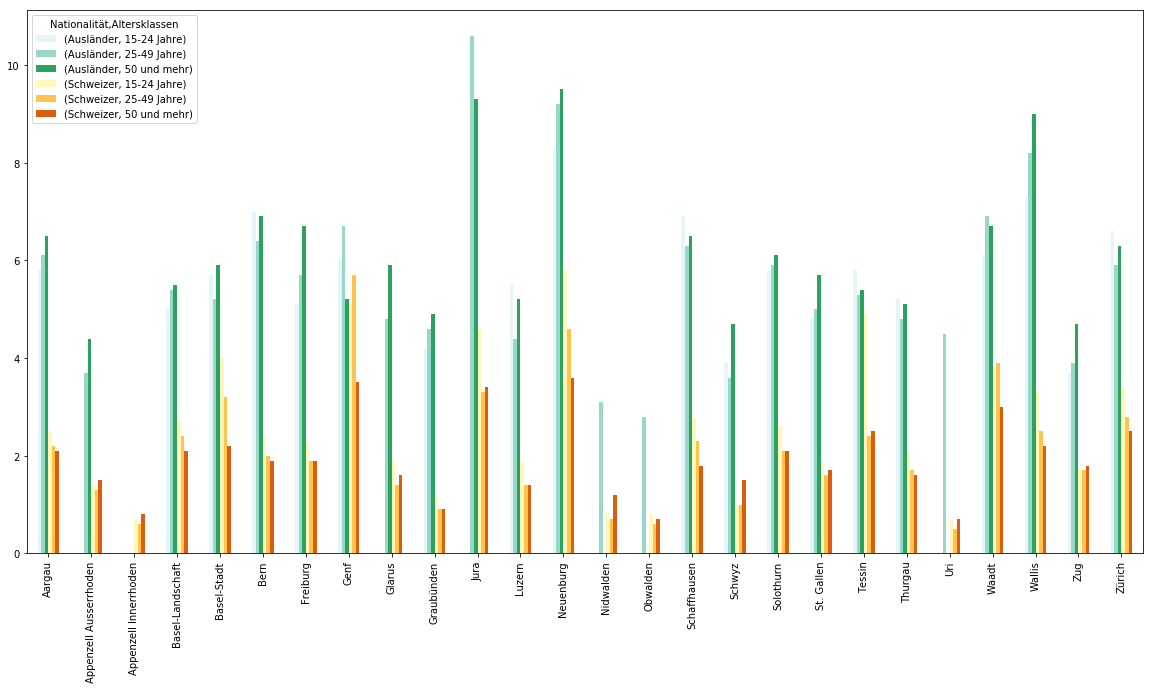

In [29]:
axes = df.plot(kind='bar',stacked=False, figsize=(20, 10),color=['#e5f5f9', '#99d8c9', '#2ca25f', '#fff7bc', '#fec44f', '#d95f0e'])